In [2]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import numpy as np
import astropy.units as u
import gammapy
import operator
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
    GaussianSpectralModel,
    CompoundSpectralModel
)
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../..')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [3]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [4]:
figformat = 'png'

In [3]:
dataset_asimov = Dataset_load.create_asimov(cutoff = True,gun = True)
simga = 0.2
mean = 5
dataset_asimov.models[0].spectral_model.parameters['sigma'].value = simga
dataset_asimov.models[0].spectral_model.parameters['mean'].value = mean

# set npred again
dataset_asimov.counts = dataset_asimov.npred()

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


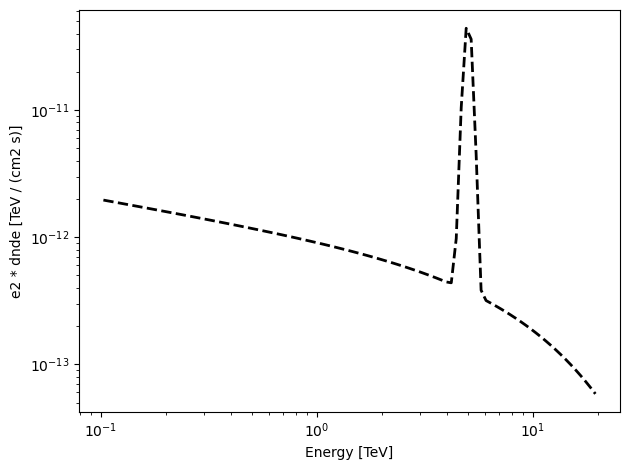

In [4]:
energy_bounds = [0.1, 20 ]* u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2,  
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
plt.tight_layout()
fig = plt.gcf()
fig.savefig(f'plots/2_spectrum_input_simga_{simga}.{figformat}')

In [5]:
zero = 1e-12

sigmass = [0.0]
simgass_assumed = [0.1]
res_assumed = 0.1
biass = [0.0]
biass_assumed = [0.1]

In [6]:
def create_dataset(b, s):
    i = 0
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=10,
                        gun = True,
                        cutoff = True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(10)
    dataset_conv_N.models.parameters['bias'].frozen  = False
    dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    
    dataset_conv_N.e_reco_n = 10

    penalising_invcovmatrix = np.zeros((4,4))
    
    np.fill_diagonal(penalising_invcovmatrix, [1/biass_assumed[i]**2, 1/simgass_assumed[i]**2, 1/zero**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    #dataset_conv_N.irf_model.eff_area_model = None
    #dataset_conv_N.irf_model.eff_area_model = None
    i +=1
    return dataset_conv, dataset_conv_N

datasets_conv =[]
datasets_conv_N =[]

for r in sigmass:
    dataset_conv, dataset_conv_N  = create_dataset(biass[0], r)
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    
dataset_conv_extreme, dataset_conv_N_extreme  = create_dataset(biass[0], 0.1)


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [7]:
dataset_conv_N.penalising_invcovmatrix

array([[1.e+02, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e+02, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e+24, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e+24]])

In [8]:
print(dataset_conv_N)

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 362617 
  Total background counts         : 360331.31
  Total excess counts             : 2286.39

  Predicted counts                : 362616.29
  Predicted background counts     : 360331.34
  Predicted excess counts         : 2284.94

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -761938.45

  Number of models                : 3 
  Number of parameters            : 21
  Number of free parameters       : 11

  Component 0: SkyMo

In [9]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


colors_standard = ['darkmagenta', 'darkred', 'darkolivegreen', 'darkred']
colors_nui = ['cornflowerblue', 'navy', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_standard = 'darkmagenta'; color_nui = 'royalblue'
color_standard_ = 'darkred'; color_nui_ = 'navy'

In [10]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_asimov.geoms['geom'].axes[0]

In [11]:
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
i =0
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        i += 1
        

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [12]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred' #mediumvioletred
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


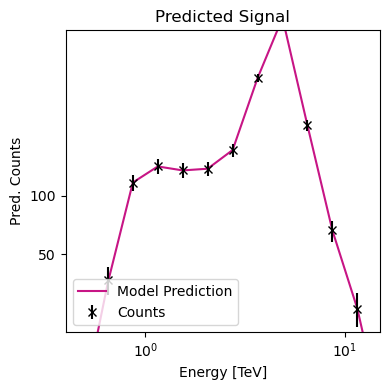

In [13]:
fig,ax = plt.subplots(1,1, sharey = True, figsize = (4,4))
ax =[ax]
plt.title("Predicted Signal")
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(energy,npreds_pre_fit[0],
         label = "Model Prediction", color = color_standard)

plt.errorbar(energy, sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data), 
             yerr = np.sqrt(sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data)),
            fmt = 'x', label = "Counts", color = 'black')

#plt.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[1],
#                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")

        
ax[0].loglog()
ax[0].legend(loc = 'lower left')
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Pred. Counts")
ax[0].set_ylim(2e1, 7e2)
plt.minorticks_off()
ax[0].set_yticks([50,100], ['50', '100'])
ax[0].set_xlim(0.4, 15)
plt.tight_layout()
fig.savefig(f"plots/2_Npred_single_simga_{simga}_{biass[0]}_cut.{figformat}")


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


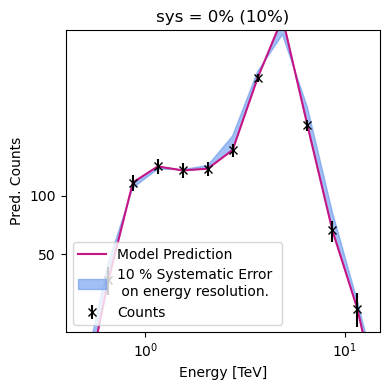

In [14]:

fig,ax = plt.subplots(1,len(datasets_conv), sharey = True, figsize =  (4,4))
if len(datasets_conv) == 1:
    ax = [ax]
for i in range(len((datasets_conv))):
    ax[i].plot(energy,npreds_pre_fit[i], label = "Model Prediction", color = color_standard)

for a in ax:
    try:
        a.fill_between(energy, npreds_pre_fit[0],sum_e(dataset_conv_extreme.npred_signal().data) ,
                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy resolution.")
    except:
        print("not enough")
    a.errorbar(energy, sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data), 
             yerr = np.sqrt(sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data)),
            fmt = 'x', label = "Counts", color = 'black')

        
    a.loglog()
    a.legend(loc = 'lower left')
    a.set_xlabel("Energy [TeV]")
    a.set_ylim(2e1, 7e2)
    a.set_yticks([50,100], ['50', '100'])
    a.set_xlim(0.4, 15)
ax[0].set_ylabel("Pred. Counts")
ax[0].set_title("sys = 0% (10%)"); 
#ax[1].set_title("sys = 0% (10%)"); ax[2].set_title("sys = 10% (10%)"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred_simga_{simga}_{biass[0]}_cut.{figformat}")


corr
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_

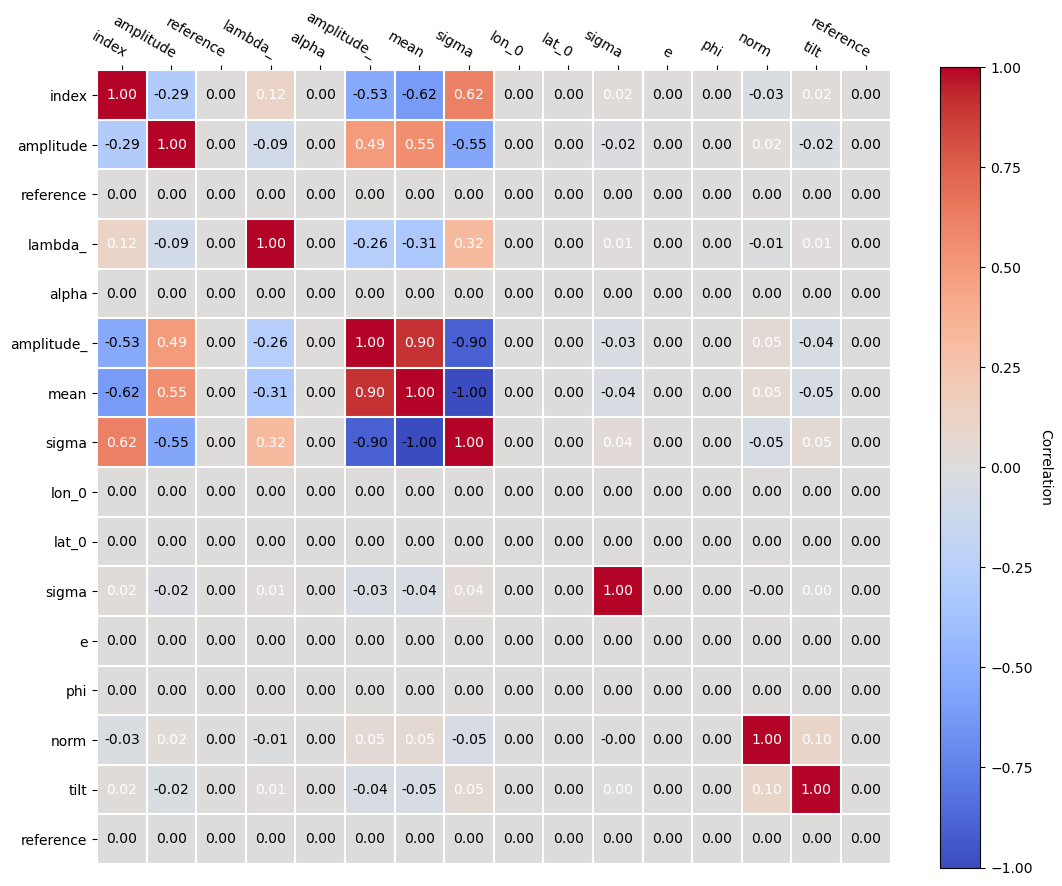

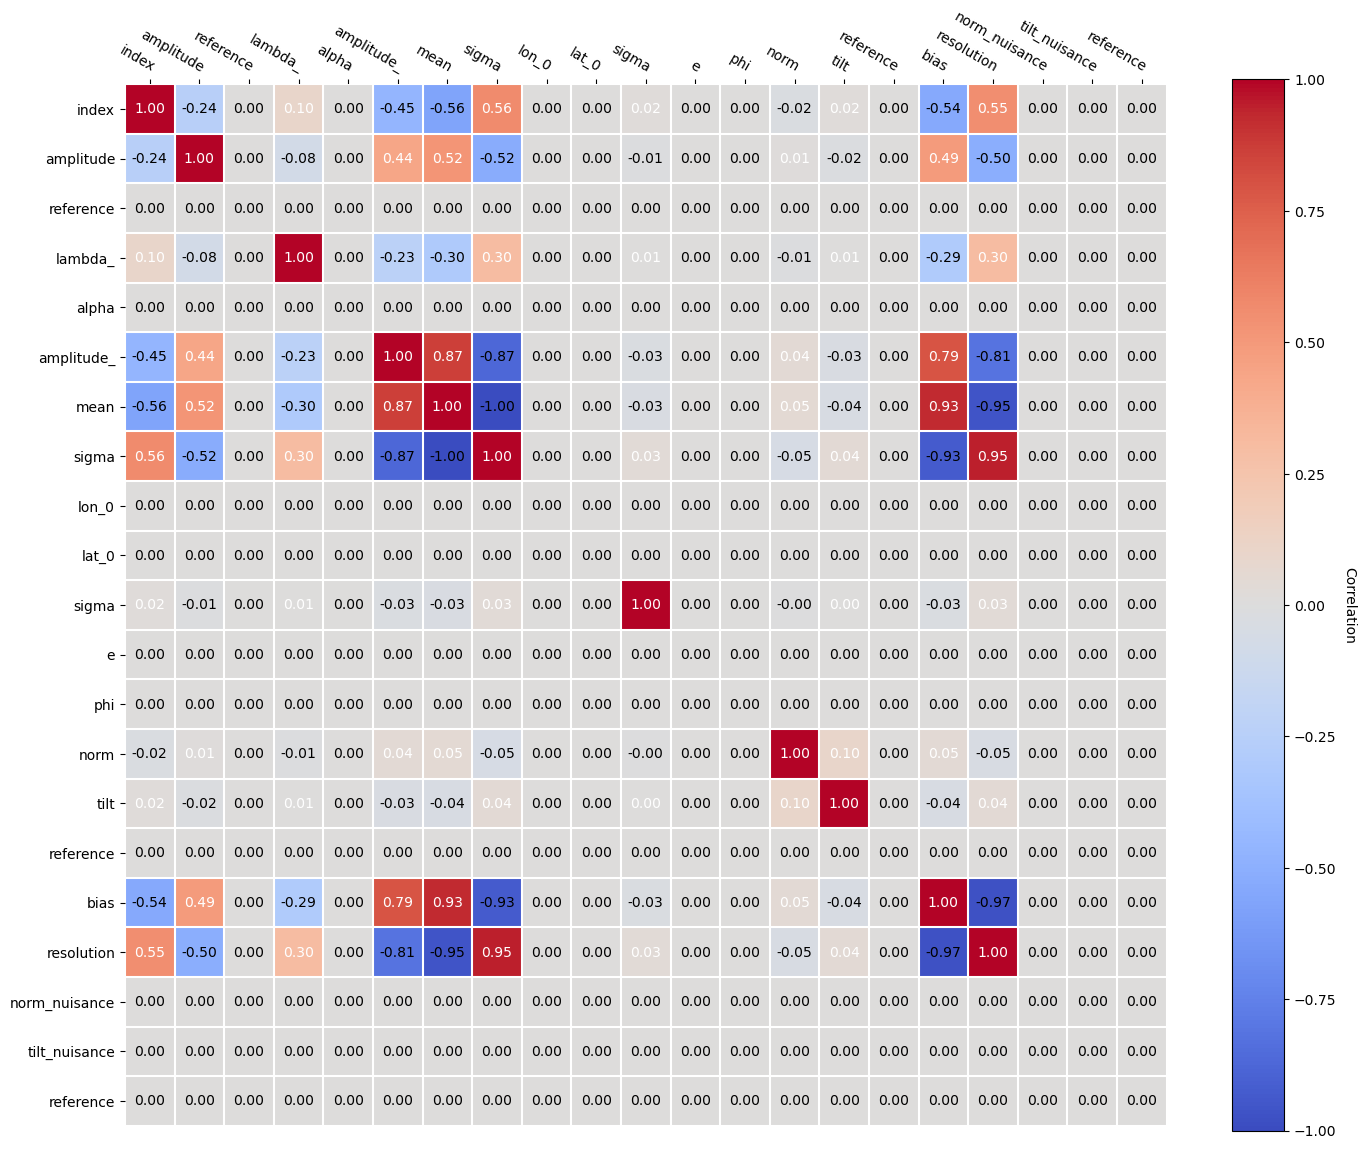

In [15]:
%%time
fitting = 1

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)

    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{simga}.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{simga}.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{simga}.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_bias_0_{sigmass[i]}_simga_{simga}.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



In [16]:
energy_bounds = [0.1,20 ] *u.TeV

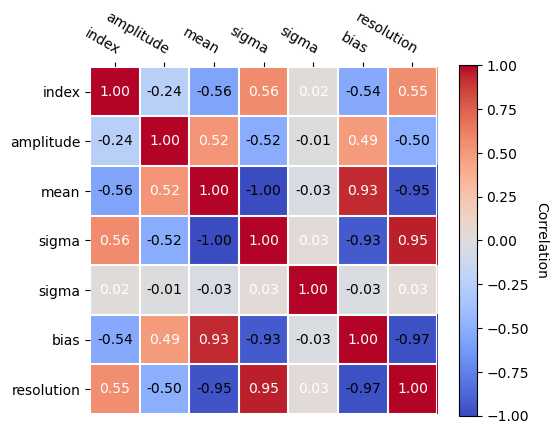

In [17]:
par_inter_names = ['index', 'amplitude', 'mean', 'sigma', 'lamda_', 'resolution', 'bias' ]
pars_inter = Parameters([_ for _ in datasets_conv_N[0].models.parameters if _.name in par_inter_names])
datasets_conv_N[0].models.covariance.get_subcovariance(pars_inter).plot_correlation()
fig = plt.gcf()
fig.savefig(f'plots/2_cov_matrix_{simga}_{biass[0]}_cut.{figformat}')


In [18]:
width = 3*len(datasets_conv)
if len(datasets_conv):
    width = 5
fig,axs = plt.subplots(1,len(datasets_conv), sharey=True,figsize = (width,4))
if len(datasets_conv)==1:
    axs = [axs]
for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5)
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_standard_e,
                                                              alpha = 0.9,
                                                              label= "1$\,\sigma_{stat}$"
                                                             )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys_assumed = 10%"); 

#axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 
#axs[1].set_ylabel(''); axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig(f'plots/2_spectrum_comparison_{biass[0]}_cut.{figformat}")


SyntaxError: EOL while scanning string literal (3001103363.py, line 43)

In [ ]:


fig,axss = plt.subplots(len(datasets_conv_N),2, sharex = True, sharey=False, figsize = (10,4))
a = axss[1]
d = datasets_conv_N[0]
d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                    color=color_nui,
                                                         label= f"Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='-', linewidth= 2)       

d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = a,
                                                       facecolor=color_nui_e,
                                                         label="1$\,\sigma_{tot}$",
                                                        alpha = 0.6)
d = datasets_conv[0]
a = axss[0]

d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                       color=color_standard,
                                                         label= f"Best Fit",
                                                        alpha = 0.95,
                                                       linestyle='-', linewidth= 2)       

d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = a,
                                                       facecolor=color_standard_e,
                                                         label="1$\,\sigma_{stat}$",
                                                        alpha = 0.5)
axss[0].set_title(f"bias={b}; res_assumed = {res_assumed}")
for a in axss:
    dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                           color='black',
                                                             label="Input",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)  
    a.legend(loc = 'upper left')
    

ylim = axss[1].get_ylim()
axss[0].set_ylim(ylim[0], ylim[1])
axss[0].set_xlabel('')
plt.tight_layout()
fig.savefig(f'plots/2_Best_fit_Spectrum_{simga}_{biass[0]}_cut.{figformat}")


In [ ]:
fig, axs = plt.subplots(4,2, figsize= (5, 6))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'norm', 'tilt',
           'mean', 'sigma', 'lambda_']
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = error, fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            ax[i].hlines(dataset_asimov.models.parameters[p].value, -0.1, 0.2,
                        color = 'darkgrey')
            
        ii +=1
labels_sys = [ 'St.', 'Nui']
for i, p in enumerate(parnames):
    value = dataset_asimov.models.parameters[p].value
    error = dataset_asimov.models.parameters[p].error    
    ax[i].hlines( value, 0, len(labels_sys)-1, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.set_ylabel('Best Fit'); 
    ax.set_xticks([0, 0.1],labels_sys)
    ax.set_xlim(-0.1, 0.2)
plt.tight_layout()
fig.savefig(f'plots/2_Best_fit_parameters_{simga}_{biass[0]}_cut.{figformat}")
    

In [ ]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = color_nui,markersize=14,)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '0%', '5%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f'plots/2_Best_fit_nui_parameters_{biass[0]}_cut.{figformat}")
    